**Data Preprocessing & Exploratory Analysis**

<ipython-input-9-0e01882cd14f>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/fred_combined_10yrs.csv', parse_dates=['DATE'])


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3651 entries, 2015-04-22 to 2025-04-19
Data columns (total 67 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DGS1MO          3651 non-null   float64
 1   DGS3MO          3651 non-null   float64
 2   DGS6MO          3651 non-null   float64
 3   DGS1            3651 non-null   float64
 4   DGS2            3651 non-null   float64
 5   DGS3            3651 non-null   float64
 6   DGS5            3651 non-null   float64
 7   DGS7            3651 non-null   float64
 8   DGS10           3651 non-null   float64
 9   DGS20           3651 non-null   float64
 10  DGS30           3651 non-null   float64
 11  DTB4WK          3651 non-null   float64
 12  DTB3            3651 non-null   float64
 13  DTB6            3651 non-null   float64
 14  BAMLH0A0HYM2    3651 non-null   float64
 15  EFFR            3651 non-null   float64
 16  IORR            3651 non-null   float64
 17  

<ipython-input-9-0e01882cd14f>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-9-0e01882cd14f>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


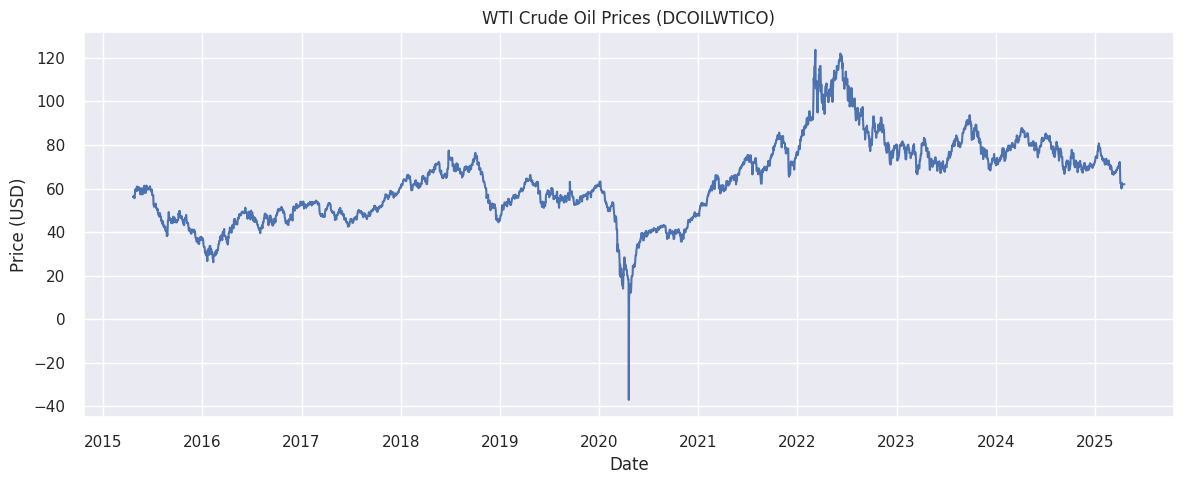

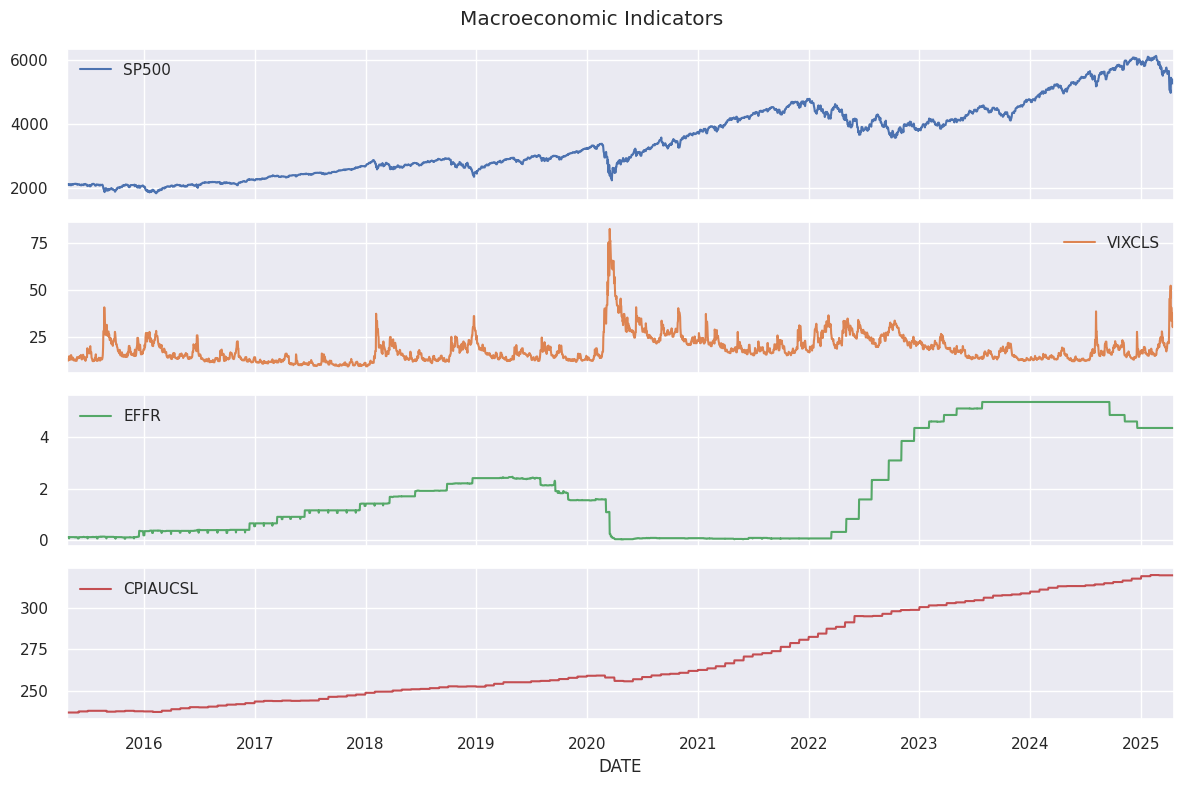

In [9]:
# Step 1.1: Load the data
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the dataset and parse dates
df = pd.read_csv('/content/fred_combined_10yrs.csv', parse_dates=['DATE'])
df.set_index('DATE', inplace=True)

# Step 1.2: Inspect the dataset
print("Dataset Info:\n")
print(df.info())
print("\nDescriptive Statistics:\n")
print(df.describe())

# Step 1.3: Check and handle missing values
missing = df.isna().sum()
print("\nMissing values per column:\n", missing)

# Forward fill then backward fill
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Step 1.4: Ensure all data is numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Step 1.5: Plot WTI Crude Oil Prices
plt.figure(figsize=(12, 5))
plt.plot(df['DCOILWTICO'])
plt.title('WTI Crude Oil Prices (DCOILWTICO)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot selected macroeconomic indicators
df[['SP500', 'VIXCLS', 'EFFR', 'CPIAUCSL']].plot(subplots=True, figsize=(12, 8), title='Macroeconomic Indicators')
plt.tight_layout()
plt.show()

# Step 1.6: Initialize scaler (will apply later during modeling phase)
scaler = StandardScaler()



**Feature Engineering**

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 2.1: Select relevant features
features = ['SP500', 'VIXCLS', 'EFFR', 'CPIAUCSL', 'DCOILWTICO']
data = df[features].copy()

# Step 2.2: Set the window size
window_size = 10

# Step 2.3: Normalize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Step 2.4: Create sequences and labels
X = []
y = []

for i in range(window_size, len(scaled_data) - 1):
    X.append(scaled_data[i - window_size:i])            # shape: (window_size, num_features)
    y.append(scaled_data[i + 1][features.index('DCOILWTICO')])  # target is next day's WTI price

X = np.array(X)
y = np.array(y)

print(f'Shape of X: {X.shape}')  # Expected: (samples, window_size, num_features)
print(f'Shape of y: {y.shape}')  # Expected: (samples,)


Shape of X: (3640, 10, 5)
Shape of y: (3640,)


**Train / Validation / Test Split**

In [11]:
# Step 3: Chronological train/val/test split
num_samples = X.shape[0]

train_size = int(num_samples * 0.8)
val_size = int(num_samples * 0.1)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (2912, 10, 5) (2912,)
Validation set: (364, 10, 5) (364,)
Test set: (364, 10, 5) (364,)


** Build, Train, and Evaluate a Feedforward Neural Network**

**Import PyTorch and Prepare **

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Flatten the input from (samples, 10, 5) to (samples, 50)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_flat, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


**Define the FNN Model**

In [13]:
class FNN(nn.Module):
    def __init__(self, input_dim):
        super(FNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

# Instantiate model
input_dim = X_train_flat.shape[1]  # 50
model = FNN(input_dim)


**Training Loop**

In [14]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_loss = criterion(val_preds, y_val_tensor).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_loss:.4f}")


Epoch 1/50 - Train Loss: 0.7149 - Val Loss: 0.0860
Epoch 2/50 - Train Loss: 0.1396 - Val Loss: 0.7581
Epoch 3/50 - Train Loss: 0.0972 - Val Loss: 0.0831
Epoch 4/50 - Train Loss: 0.0848 - Val Loss: 0.0467
Epoch 5/50 - Train Loss: 0.1507 - Val Loss: 0.0637
Epoch 6/50 - Train Loss: 0.1333 - Val Loss: 0.0404
Epoch 7/50 - Train Loss: 0.2972 - Val Loss: 0.0572
Epoch 8/50 - Train Loss: 0.0692 - Val Loss: 0.1097
Epoch 9/50 - Train Loss: 0.0840 - Val Loss: 0.0338
Epoch 10/50 - Train Loss: 0.0814 - Val Loss: 0.0370
Epoch 11/50 - Train Loss: 0.1476 - Val Loss: 0.0381
Epoch 12/50 - Train Loss: 0.1052 - Val Loss: 0.0352
Epoch 13/50 - Train Loss: 0.1833 - Val Loss: 0.0561
Epoch 14/50 - Train Loss: 0.0719 - Val Loss: 0.0391
Epoch 15/50 - Train Loss: 0.1167 - Val Loss: 0.0409
Epoch 16/50 - Train Loss: 0.0774 - Val Loss: 0.0341
Epoch 17/50 - Train Loss: 0.1242 - Val Loss: 0.0458
Epoch 18/50 - Train Loss: 0.0758 - Val Loss: 0.0334
Epoch 19/50 - Train Loss: 0.1070 - Val Loss: 0.0422
Epoch 20/50 - Train L

**Plot Loss Curves**

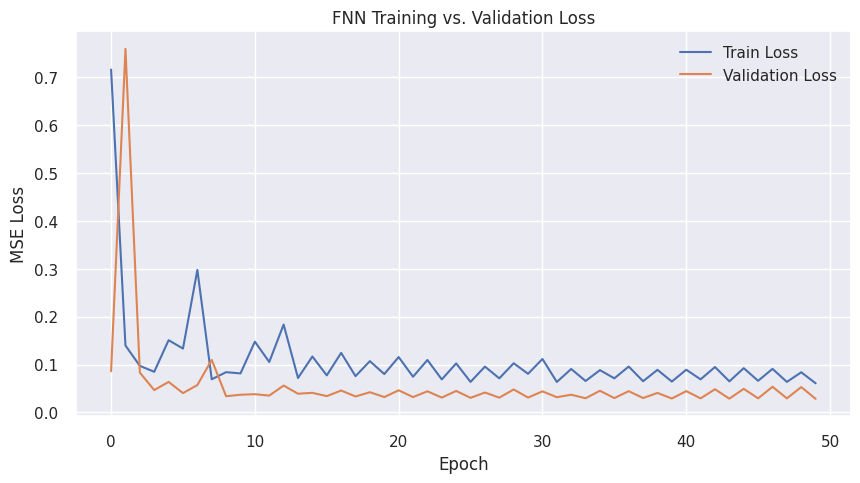

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('FNN Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


**Evaluate FNN on Test Set**

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Ensure model is in eval mode
model.eval()

# Get predictions
with torch.no_grad():
    y_test_pred = model(X_test_tensor).numpy()

# Reverse standardization if needed (optional, only if you want to rescale to real prices)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")


Test RMSE: 0.2571
Test MAE: 0.2165
Test MAPE: 116.23%


**Plot Predictions vs. Actuals**

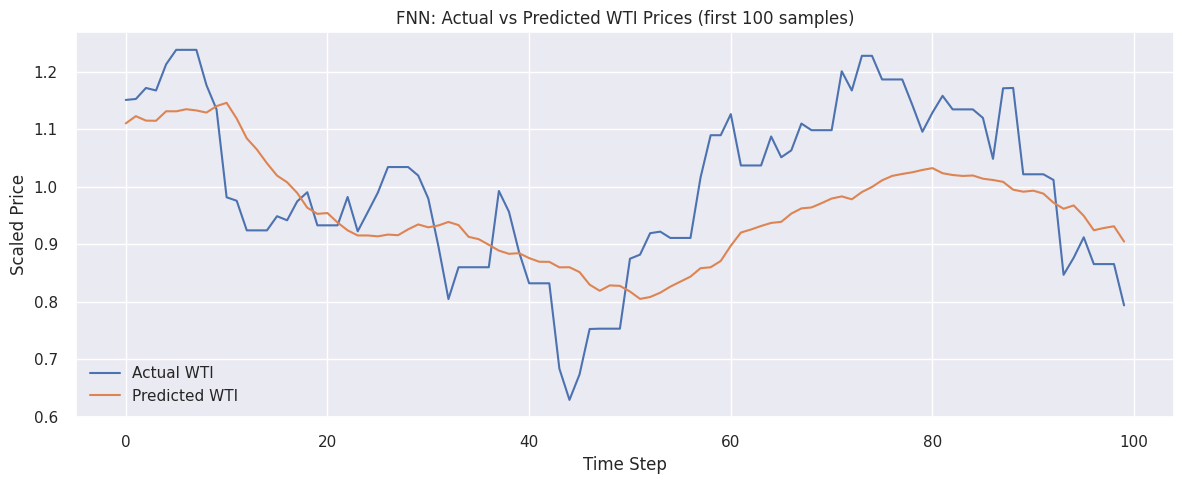

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label='Actual WTI')
plt.plot(y_test_pred[:100], label='Predicted WTI')
plt.title('FNN: Actual vs Predicted WTI Prices (first 100 samples)')
plt.xlabel('Time Step')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Reshape Inputs for CNN**

In [18]:
# Reshape for CNN: (samples, features, window_size)
X_train_cnn = np.transpose(X_train, (0, 2, 1))
X_val_cnn = np.transpose(X_val, (0, 2, 1))
X_test_cnn = np.transpose(X_test, (0, 2, 1))

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_cnn, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


**Define the CNN Model**

In [19]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=16, kernel_size=3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x).squeeze()

model = CNN1D()


**Train the CNN**

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_loss = criterion(val_preds, y_val_tensor).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_loss:.4f}")


Epoch 1/50 - Train Loss: 1.2047 - Val Loss: 0.6867
Epoch 2/50 - Train Loss: 0.7507 - Val Loss: 0.4166
Epoch 3/50 - Train Loss: 0.4914 - Val Loss: 0.2316
Epoch 4/50 - Train Loss: 0.3081 - Val Loss: 0.1164
Epoch 5/50 - Train Loss: 0.1892 - Val Loss: 0.0658
Epoch 6/50 - Train Loss: 0.1216 - Val Loss: 0.0527
Epoch 7/50 - Train Loss: 0.0885 - Val Loss: 0.0501
Epoch 8/50 - Train Loss: 0.0736 - Val Loss: 0.0484
Epoch 9/50 - Train Loss: 0.0661 - Val Loss: 0.0480
Epoch 10/50 - Train Loss: 0.0600 - Val Loss: 0.0503
Epoch 11/50 - Train Loss: 0.0562 - Val Loss: 0.0547
Epoch 12/50 - Train Loss: 0.0526 - Val Loss: 0.0601
Epoch 13/50 - Train Loss: 0.0491 - Val Loss: 0.0651
Epoch 14/50 - Train Loss: 0.0465 - Val Loss: 0.0696
Epoch 15/50 - Train Loss: 0.0441 - Val Loss: 0.0737
Epoch 16/50 - Train Loss: 0.0414 - Val Loss: 0.0772
Epoch 17/50 - Train Loss: 0.0393 - Val Loss: 0.0810
Epoch 18/50 - Train Loss: 0.0374 - Val Loss: 0.0836
Epoch 19/50 - Train Loss: 0.0355 - Val Loss: 0.0850
Epoch 20/50 - Train L

**Plot CNN Loss Curve**

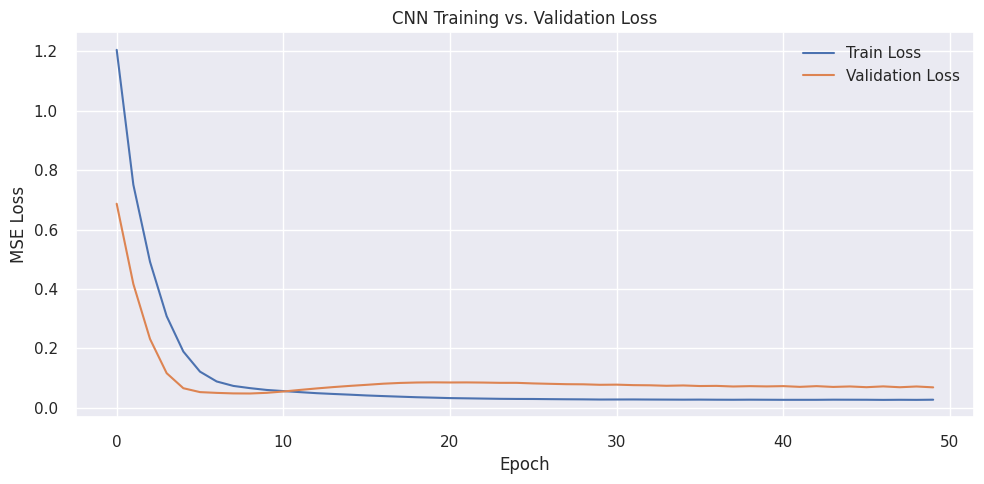

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('CNN Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**CNN: Test Evaluation Code**

In [22]:
# Ensure model is in evaluation mode
model.eval()

# Predict on test data
with torch.no_grad():
    y_test_pred = model(X_test_tensor).numpy()

# Compute evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print(f"CNN Test RMSE: {rmse:.4f}")
print(f"CNN Test MAE: {mae:.4f}")
print(f"CNN Test MAPE: {mape:.2f}%")


CNN Test RMSE: 0.2459
CNN Test MAE: 0.2112
CNN Test MAPE: 116.58%


** CNN: Plot Predictions vs Actuals**

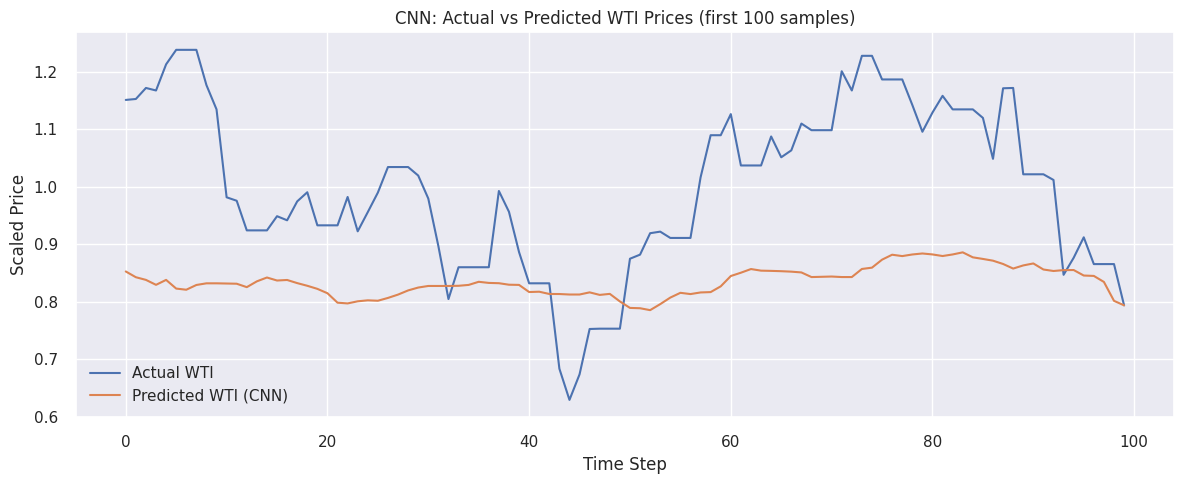

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label='Actual WTI')
plt.plot(y_test_pred[:100], label='Predicted WTI (CNN)')
plt.title('CNN: Actual vs Predicted WTI Prices (first 100 samples)')
plt.xlabel('Time Step')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Prepare Data for LSTM**

In [24]:
# No reshaping needed: X already has shape (samples, window_size, features)
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


**Define the LSTM Model**

In [25]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Take the last time step
        return self.fc(out).squeeze()

# Initialize the model
input_size = X_train.shape[2]  # 5 features
model = LSTMModel(input_size)


**Train the LSTM**

In [26]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_loss = criterion(val_preds, y_val_tensor).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_loss:.4f}")


Epoch 1/50 - Train Loss: 0.7932 - Val Loss: 0.2466
Epoch 2/50 - Train Loss: 0.2940 - Val Loss: 0.1365
Epoch 3/50 - Train Loss: 0.1326 - Val Loss: 0.1040
Epoch 4/50 - Train Loss: 0.1520 - Val Loss: 0.0480
Epoch 5/50 - Train Loss: 0.1018 - Val Loss: 0.0601
Epoch 6/50 - Train Loss: 0.1920 - Val Loss: 0.0600
Epoch 7/50 - Train Loss: 0.0595 - Val Loss: 0.0379
Epoch 8/50 - Train Loss: 0.0844 - Val Loss: 0.0435
Epoch 9/50 - Train Loss: 0.0640 - Val Loss: 0.0576
Epoch 10/50 - Train Loss: 0.1288 - Val Loss: 0.0513
Epoch 11/50 - Train Loss: 0.0673 - Val Loss: 0.0379
Epoch 12/50 - Train Loss: 0.0840 - Val Loss: 0.0670
Epoch 13/50 - Train Loss: 0.0649 - Val Loss: 0.0384
Epoch 14/50 - Train Loss: 0.0926 - Val Loss: 0.0558
Epoch 15/50 - Train Loss: 0.0422 - Val Loss: 0.0317
Epoch 16/50 - Train Loss: 0.0533 - Val Loss: 0.0387
Epoch 17/50 - Train Loss: 0.0461 - Val Loss: 0.0447
Epoch 18/50 - Train Loss: 0.0617 - Val Loss: 0.0427
Epoch 19/50 - Train Loss: 0.0442 - Val Loss: 0.0355
Epoch 20/50 - Train L

**Plot Training vs. Validation Loss**

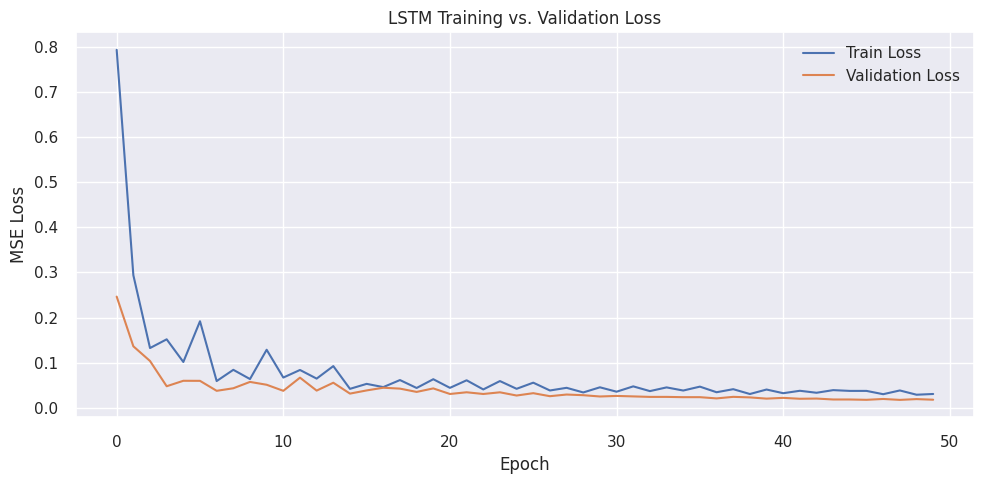

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**LSTM Test Evaluation & Plot**

In [28]:
# Predict on test set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).numpy()

# Compute test metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print(f"LSTM Test RMSE: {rmse:.4f}")
print(f"LSTM Test MAE: {mae:.4f}")
print(f"LSTM Test MAPE: {mape:.2f}%")


LSTM Test RMSE: 0.1902
LSTM Test MAE: 0.1600
LSTM Test MAPE: 74.96%


**Plot Predictions vs Actuals (LSTM)**

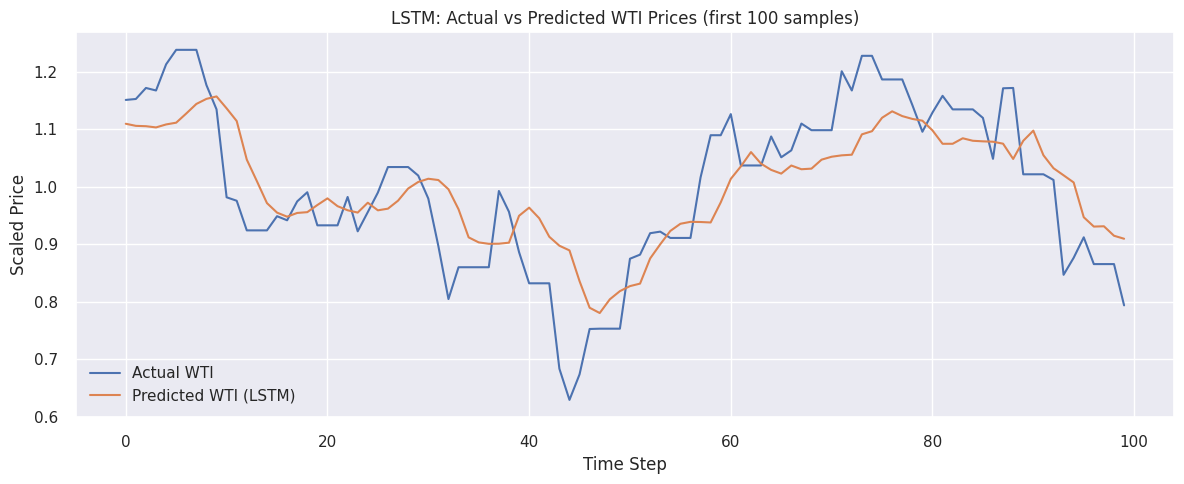

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label='Actual WTI')
plt.plot(y_test_pred[:100], label='Predicted WTI (LSTM)')
plt.title('LSTM: Actual vs Predicted WTI Prices (first 100 samples)')
plt.xlabel('Time Step')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
